In [1]:
%matplotlib notebook

import os
import glob
import copy
import requests
import json

import numpy as np

import astropy
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
from astropy.time import Time
from astropy.table import Table, vstack
from astropy.stats import SigmaClip
from astropy.coordinates import SkyCoord
from astropy.nddata.utils import Cutout2D

from astroquery.imcce import Skybot

import matplotlib.pyplot as plt

from plot_utils import iter_over_obj, plot_all_objs, plot_focal_plane, plot_cutouts, plot_img

# Objects crossing COSMOS 1 field of DDF in 2021

## DDF and COSMOS 1 Field

The Deep Drilling Field (DDF) is an optical imaging survey conducted with the Dark Energy Camera (DECam) on the 4-m Blanco telescope at the Cerro Tololo Inter-American Observatory (CTIO) repeatedly images several fields (refered to as COSMOS 1, 2 and 3 and DECals). The part of survey considered here covers the target named "COSMOS 1" over ~40 epochs (nights) per field and 5 to 6 images per night per filter in g, r, i, and/or z. The subset covers the timespan from 2021-03-19 to 2022-01-24 (21A and 21B halves). 

The survey is described in more depth in [this paper](https://ui.adsabs.harvard.edu/abs/2023MNRAS.519.3881G/abstract). 

The COSMOS 1 field is generally located at:

In [2]:
ra_center = 150.002625
dec_center = 3.09713889
radius = 1.15 # degrees

To follow along this notebook download an example of the primary pointing:

In [3]:
# To get the primary pointing uncomment and execute cell
#!wget https://astroarchive.noirlab.edu/api/retrieve/c1db52de6dad0d8a4068fdd4a8e35e1c/

We mainly need this to build the bounding boxes of a single exposure to contextualize the tracks across the field.

The exposure filters and dates in the COSMOS 1 field can be retrieved from Astro Data Archive advanced search API:

## Objects transiting the FOV in 2021

In this section we'll take a peek at some of the properties of known objects that were returned in the previous section. If you're relying on the data provided in the repository, this is where you should start.

The following code assumed you have access to at least 1 example field in order to properly draw bounding boxes and that the `known_objects_in_cosmos_1.ecsv` exists as in format expected.

In [4]:
img = fits.open("c4d_210319_003604_ooi_g_v1.fits")
objects = Table.read("known_objects_in_cosmos_1_calibrated_exps.ecsv")

In [5]:
# lol, wtf is wrong with the original dataset if 
# the number of unique magnitudes is only 106 - 
# there should be ~2k objects, and ~20k ephemerids
unique_mags = list(set(objects["V"]))
unique_mags.sort()


# I want to use objects max mag to create a list
# of the objects sorted (descending) on mags.
# But same object could appear multiple times because
# it grows brighter and dimmer (potentially) so we 
# create a list of observations based on magnitudes
# then de-duplicate while preserving order. This
# should result in a list of object names, sorted
# in descending order of magnitudes based on their
# brightest mag observation.
brightest_to_dimmest = []
for um in unique_mags:
    objs = objects[objects["V"] == um]["Name"]
    brightest_to_dimmest.extend(objs)

lookup = set()
brightest_to_dimmest = [obj for obj in brightest_to_dimmest if obj not in lookup and lookup.add(obj) is None]

<IPython.core.display.Javascript object>


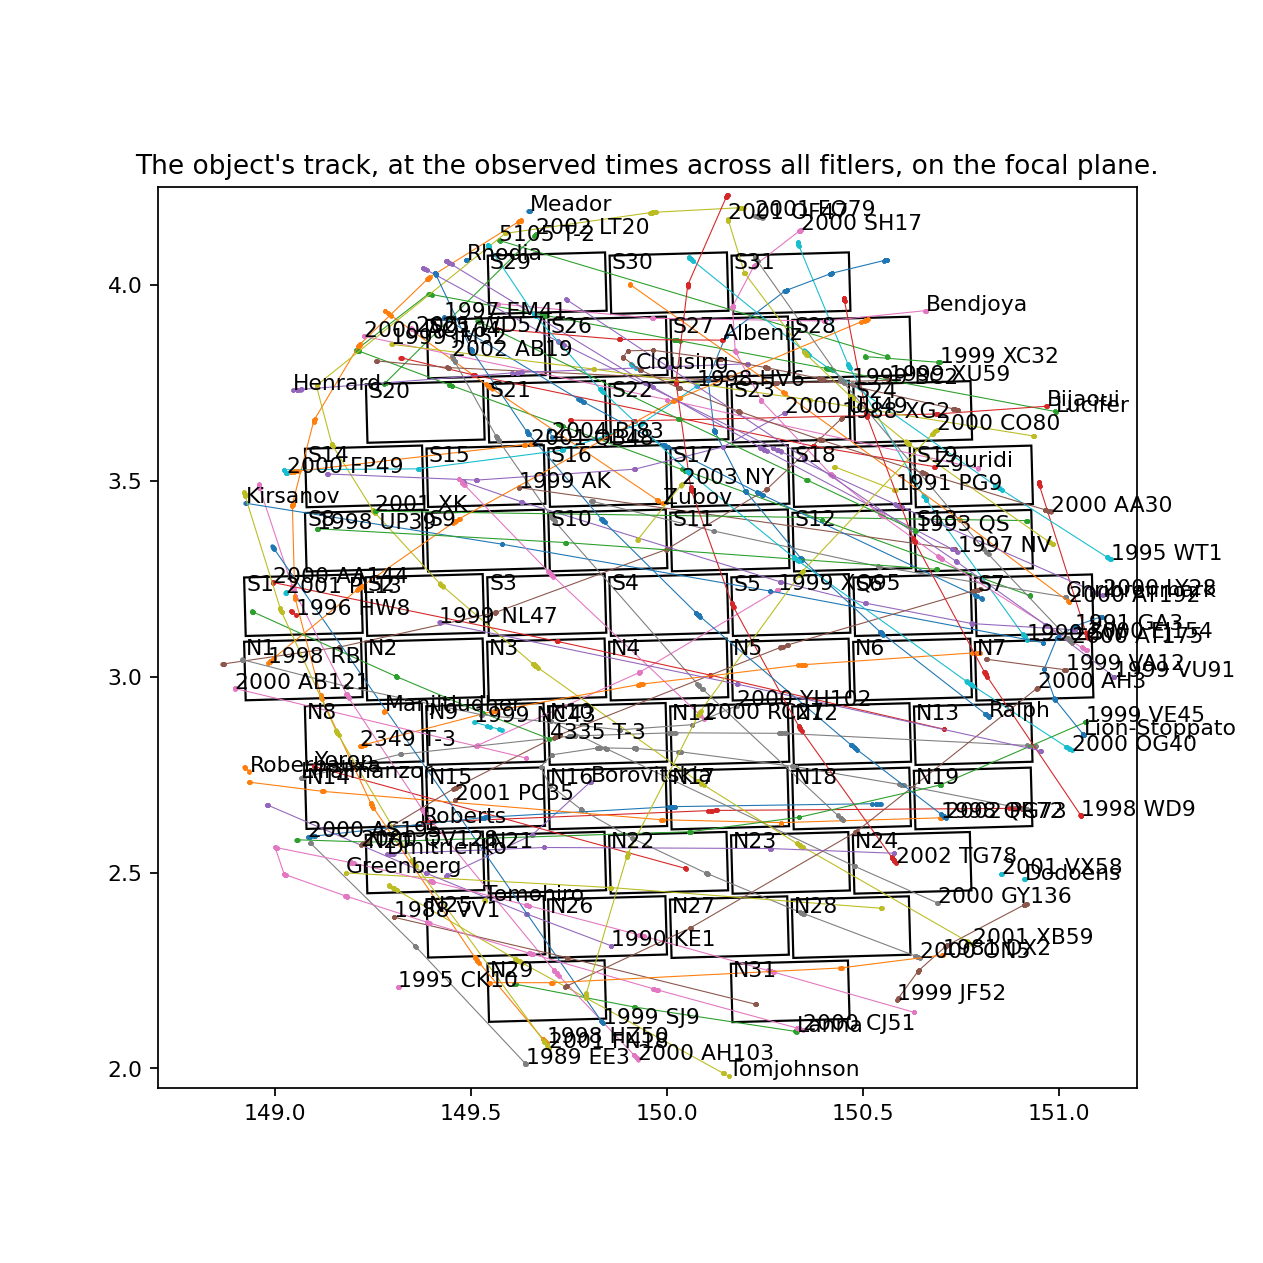

In [6]:
fig, ax = plt.subplots(figsize=(8, 8))

nobjs = 100

plot_focal_plane(ax, img)
i = 0
for objname in brightest_to_dimmest:
    obj = objects[objects["Name"] == objname] 
    ax.plot(obj["RA"], obj["DEC"], label=obj["Name"][0], marker="o", lw=0.5, ms=1)
    ax.text(obj["RA"][0], obj["DEC"][0], obj["Name"][0])
    i += 1
    if i >= nobjs:
        break
    
    
ax.set_title("The object's track, at the observed times across all fitlers, on the focal plane.")
ax.set_xlim(148.7, 151.2)
ax.set_ylim(1.95, 4.25)
ax.set_aspect("equal")
#fig.legend()

The object could have been observed a total of 124 times in any filter.


<IPython.core.display.Javascript object>


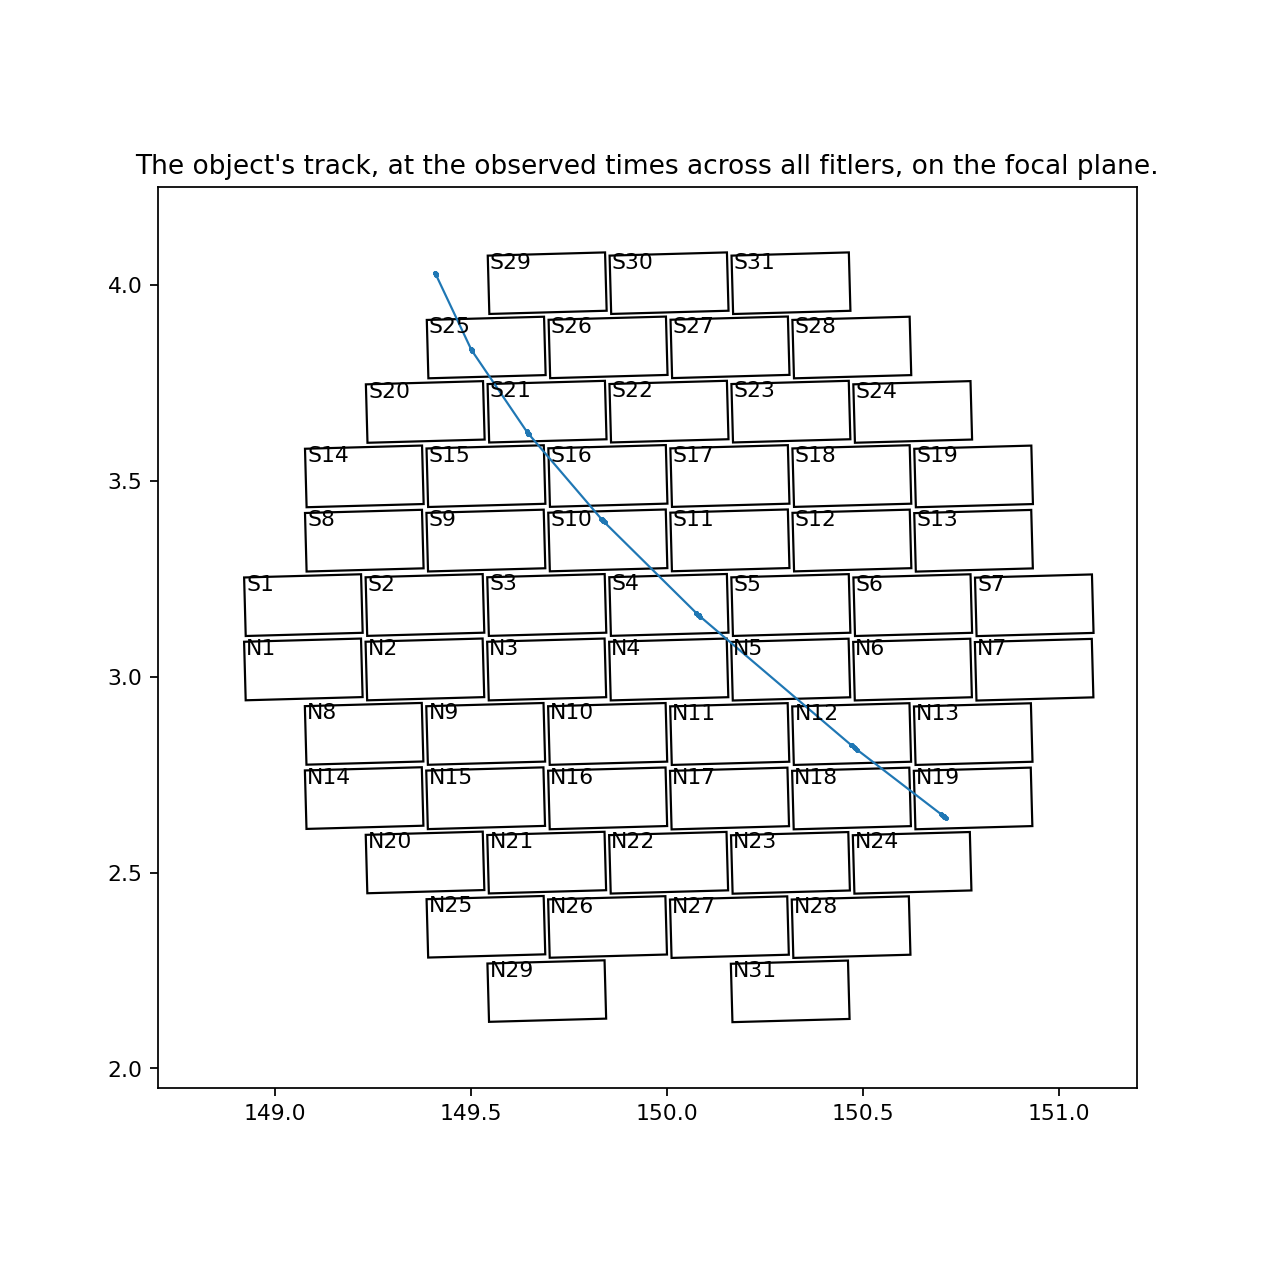

In [7]:
obj_only = objects[objects["Name"] == "2002 PG73"]
print(f"The object could have been observed a total of {len(obj_only)} times in any filter.")

fig, ax = plt.subplots(figsize=(8, 8))

plot_focal_plane(ax, img)
plot_all_objs(ax, obj_only, (ra_center, dec_center), show_field=False, lw=1, ms=1.1)

ax.set_title("The object's track, at the observed times across all fitlers, on the focal plane.")
ax.set_xlim(148.7, 151.2)
ax.set_ylim(1.95, 4.25)
ax.set_aspect("equal")

In [8]:
root = "2002_PG73"

def extract_metadata(root, force=False, default_exported_table="2002_PG73_extracted_fits_metadata.ecsv"):
    # Ah, screw it, I have to unravel everything in a table because 
    # I can't find even a very bright object in these images and I'm not sure what's 
    # going on
    images = Table(names=["fname", "detpos", "ccdnum", "obstime", "filter", "band", "bbox", "wcs"], 
                   dtype=[str,          str,      int,    object,      str,    str, object, object])

    if not force and os.path.exists(default_exported_table):
        images = Table.read(default_exported_table)
        wcss = [WCS(wcs) for wcs in images["wcs"]]
        images["wcs"] = wcss
        times = [Time(t) for t in images["obstime"]]
        images["obstime"] = times
        return images
    
    wcss, times = [], []
    for fp in glob.glob(f"{root}/*/*fits.fz"):
        hdul = fits.open(fp)
        fname = fp.split(os.sep)[-1]
        obstime = hdul["PRIMARY"].header["DATE-OBS"]
        band = hdul["PRIMARY"].header["FILTER"]
        for hdu in hdul:
            wcs = WCS(hdu.header)
            bbox = wcs.calc_footprint()
            if bbox is not None:
                wcss.append(wcs)
                times.append(Time(obstime))
                images.add_row([
                    fname,
                    hdu.header["DETPOS"],
                    hdu.header["CCDNUM"],
                    obstime,
                    band[0],
                    band,
                    bbox,
                    wcs.to_header_string()
                ])
                
    images.meta["comment"] = ("DDF COSMOS 1 field FITS files made in 2021 are downloaded at the "
                              "time-stamps of when object 202_PG73 was transiting the field; had "
                              "their metadata extracted and placed in an Astropy Table object. "
                              f"Created {Time.now()}")
    images.write()
    images["wcs"] = wcss
    images["obstime"] = times
                
    return images

images = extract_metadata(root)

times = [Time(t) for t in obj_only["obstime"]]
obj_only["obstime"] = times

In [36]:
cutoutsize = 100

cutouts = Table(
    names=["obs_num", "fname", "detpos", "filter", "cutout"],
    dtype=[     str,     str,      str,      str,   object]
)


for i, observation in enumerate(obj_only):
    print(i)
    timestamp_mask = (abs(images["obstime"] - observation["obstime"])) < 15*u.s
    
    ephem = SkyCoord(observation["RA"]*u.deg, observation["DEC"]*u.deg)
    for j, hdu in enumerate(images[timestamp_mask]):
        if hdu["wcs"].footprint_contains(ephem):
            print(f"    {j}", end=", ")
            cutouts.add_row([
                observation["Number"],
                hdu["fname"],
                hdu["detpos"],
                hdu["filter"],
                Cutout2D(hdu.data, ephem, cutoutsize, wcs=hdu["wcs"])
            ])    
            

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123


In [32]:
cutouts

obs_num,fname,detpos,filter,cutout
str1,str1,str1,str1,object


In [23]:
images[timestamp_mask][0]["wcs"]

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 150.0017423512  3.096353211206  
CRPIX : 13422.2  6306.333  
PC1_1 PC1_2  : -6.866461411581e-08  7.285854543115e-05  
PC2_1 PC2_2  : -7.285778140066e-05  -4.982700118701e-08  
CDELT : 1.0  1.0  
NAXIS : 0  0

In [107]:
min(abs(images["obstime"][0] - obj_only["obstime"])).to(u.s)

<Quantity 15. s>

In [24]:
images

fname,detpos,ccdnum,obstime,filter,band,bbox,wcs
str34,str3,int64,Time,str1,str32,object,object
c4d_210328_013735_ooi_r_v1.fits.fz,S29,1,2021-03-28T01:37:35.409,r,r DECam SDSS c0002 6415.0 1480.0,[[149.54214164 4.07470407]\n [149.84177329 4.07475152]\n [149.84159163 3.92579093]\n [149.5419483 3.92559547]],WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE : 'RA---TAN' 'DEC--TAN' \nCRVAL : 150.0022571638 3.095990028206 \nCRPIX : 13422.2 6306.333 \nPC1_1 PC1_2 : -7.192336928623e-08 7.28553171497e-05 \nPC2_1 PC2_2 : -7.285727154354e-05 -6.141009930499e-08 \nCDELT : 1.0 1.0 \nNAXIS : 0 0
c4d_210328_013735_ooi_r_v1.fits.fz,S30,2,2021-03-28T01:37:35.409,r,r DECam SDSS c0002 6415.0 1480.0,[[149.85323676 4.07467313]\n [150.152954 4.07390044]\n [150.15262079 3.92495397]\n [149.85278575 3.92571737]],WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE : 'RA---TAN' 'DEC--TAN' \nCRVAL : 150.0022571638 3.095990028206 \nCRPIX : 13422.2 2047.0 \nPC1_1 PC1_2 : -7.192336928623e-08 7.28553171497e-05 \nPC2_1 PC2_2 : -7.285727154354e-05 -6.141009930499e-08 \nCDELT : 1.0 1.0 \nNAXIS : 0 0
c4d_210328_013735_ooi_r_v1.fits.fz,S31,3,2021-03-28T01:37:35.409,r,r DECam SDSS c0002 6415.0 1480.0,[[150.16455567 4.07457188]\n [150.46419298 4.07400778]\n [150.46411751 3.92490756]\n [150.16446723 3.92561812]],WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE : 'RA---TAN' 'DEC--TAN' \nCRVAL : 150.0022571638 3.095990028206 \nCRPIX : 13422.2 -2212.333 \nPC1_1 PC1_2 : -7.192336928623e-08 7.28553171497e-05 \nPC2_1 PC2_2 : -7.285727154354e-05 -6.141009930499e-08 \nCDELT : 1.0 1.0 \nNAXIS : 0 0
c4d_210328_013735_ooi_r_v1.fits.fz,S25,4,2021-03-28T01:37:35.409,r,r DECam SDSS c0002 6415.0 1480.0,[[149.38648769 3.91055341]\n [149.68597673 3.91081969]\n [149.68569397 3.76174931]\n [149.38622124 3.76141523]],WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE : 'RA---TAN' 'DEC--TAN' \nCRVAL : 150.0022571638 3.095990028206 \nCRPIX : 11167.8 8436.0 \nPC1_1 PC1_2 : -7.192336928623e-08 7.28553171497e-05 \nPC2_1 PC2_2 : -7.285727154354e-05 -6.141009930499e-08 \nCDELT : 1.0 1.0 \nNAXIS : 0 0
c4d_210328_013735_ooi_r_v1.fits.fz,S26,5,2021-03-28T01:37:35.409,r,r DECam SDSS c0002 6415.0 1480.0,[[149.69746367 3.91088041]\n [149.99725609 3.91099657]\n [149.9971797 3.7619361 ]\n [149.69725535 3.76182338]],WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE : 'RA---TAN' 'DEC--TAN' \nCRVAL : 150.0022571638 3.095990028206 \nCRPIX : 11167.8 4176.667 \nPC1_1 PC1_2 : -7.192336928623e-08 7.28553171497e-05 \nPC2_1 PC2_2 : -7.285727154354e-05 -6.141009930499e-08 \nCDELT : 1.0 1.0 \nNAXIS : 0 0
c4d_210328_013735_ooi_r_v1.fits.fz,S27,6,2021-03-28T01:37:35.409,r,r DECam SDSS c0002 6415.0 1480.0,[[150.00881585 3.91095322]\n [150.30861342 3.91037141]\n [150.30856112 3.76130624]\n [150.00863307 3.7618964 ]],WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE : 'RA---TAN' 'DEC--TAN' \nCRVAL : 150.0022571638 3.095990028206 \nCRPIX : 11167.8 -82.66665 \nPC1_1 PC1_2 : -7.192336928623e-08 7.28553171497e-05 \nPC2_1 PC2_2 : -7.285727154354e-05 -6.141009930499e-08 \nCDELT : 1.0 1.0 \nNAXIS : 0 0
...,...,...,...,...,...,...,...
c4d_210406_004510_ooi_g_v1.fits.fz,N24,55,2021-04-06T00:45:10.980,g,g DECam SDSS c0001 4720.0 1520.0,[[150.47640628 2.59425133]\n [150.77531509 2.59438369]\n [150.77490553 2.44513461]\n [150.47600838 2.44501151]],WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE : 'RA---TAN' 'DEC--TAN' \nCRVAL : 150.0043438937 3.095754365348 \nCRPIX : -6867.4 -6471.667 \nPC1_1 PC1_2 : -6.09121527839e-08 7.285222484373e-05 \nPC2_1 PC2_2 : -7.285565652553e-05 -5.292185839671e-08 \nCDELT : 1.0 1.0 \nNAXIS : 0 0
c4d_210406_004510_ooi_g_v1.fits.fz,N25,56,2021-04-06T00:45:10.980,g,g DECam SDSS c0001 4720.0 1520.0,[[149.38801001 2.43099002]\n [149.68711738 2.43040921]\n [149.68720652 2.28134925]\n [149.38815818 2.28184008]],WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE : 'RA---TAN' 'DEC--TAN' \nCRVAL : 150.0043438937 3.095754365348 \nCRPIX : -9121.8 8436.0 \nPC1_1 PC1_2 : -6.09121527839e-08 7.285222484373e-05 \nPC2_1 PC2_2 : -7.285565652553e-05 -5.292185

In [113]:
obj_only

Number,Name,RA,DEC,Type,V,posunc,centerdist,RA_rate,DEC_rate,geodist,heliodist,alpha,elong,x,y,z,vx,vy,vz,epoch,fname,obstime,filter
,,deg,deg,,mag,arcsec,arcsec,arcsec / h,arcsec / h,AU,AU,deg,deg,AU,AU,AU,AU / d,AU / d,AU / d,d,,,
int64,str15,float64,float64,str18,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str34,Time,str32
78316,2002 PG73,150.71336791666664,2.639376111111111,MB>Outer,19.0,0.092,3040.962,-17.9763,13.385,2.03592204044,2.94576125266,9.96,149.34,-2.750547165,1.022971373,0.103277652,-0.003596905,-0.008904569,-0.0033892,2459290.0,c4d_210322_003706_ooi_g_v1.fits.fz,2021-03-22T00:37:36.796,g DECam SDSS c0001 4720.0 1520.0
78316,2002 PG73,150.71322625,2.6394816666666667,MB>Outer,19.0,0.092,3040.328,-17.9754,13.385,2.03592983771,2.94576142641,9.96,149.34,-2.750547165,1.022971373,0.103277652,-0.003596905,-0.008904569,-0.0033892,2459290.0,c4d_210322_003835_ooi_r_v1.fits.fz,2021-03-22T00:39:18.151,r DECam SDSS c0002 6415.0 1480.0
78316,2002 PG73,150.71303749999998,2.6396219444444444,MB>Outer,19.0,0.092,3039.483,-17.9743,13.384,2.03594023459,2.94576165808,9.96,149.34,-2.750547165,1.022971373,0.103277652,-0.003596905,-0.008904569,-0.0033892,2459290.0,c4d_210322_004029_ooi_i_v1.fits.fz,2021-03-22T00:41:34.183,i DECam SDSS c0003 7835.0 1470.0
78316,2002 PG73,150.70826624999998,2.6431730555555557,MB>Outer,19.0,0.092,3018.131,-17.945,13.378,2.03620333199,2.94576751702,9.98,149.29,-2.750547165,1.022971373,0.103277652,-0.003596905,-0.008904569,-0.0033892,2459290.0,c4d_210322_013848_ooi_g_v1.fits.fz,2021-03-22T01:38:53.359,g DECam SDSS c0001 4720.0 1520.0
78316,2002 PG73,150.70808874999997,2.643305,MB>Outer,19.0,0.092,3017.337,-17.9439,13.378,2.03621313171,2.94576773512,9.98,149.29,-2.750547165,1.022971373,0.103277652,-0.003596905,-0.008904569,-0.0033892,2459290.0,c4d_210322_014031_ooi_g_v1.fits.fz,2021-03-22T01:41:01.533,g DECam SDSS c0001 4720.0 1520.0
78316,2002 PG73,150.7079458333333,2.643411388888889,MB>Outer,19.0,0.092,3016.698,-17.9431,13.378,2.0362210178,2.94576791062,9.98,149.29,-2.750547165,1.022971373,0.103277652,-0.003596905,-0.008904569,-0.0033892,2459290.0,c4d_210322_014201_ooi_r_v1.fits.fz,2021-03-22T01:42:44.113,r DECam SDSS c0002 6415.0 1480.0
78316,2002 PG73,150.70775874999998,2.6435508333333333,MB>Outer,19.0,0.092,3015.86,-17.9419,13.378,2.03623135444,2.94576814065,9.98,149.29,-2.750547165,1.022971373,0.103277652,-0.003596905,-0.008904569,-0.0033892,2459290.0,c4d_210322_014354_ooi_i_v1.fits.fz,2021-03-22T01:44:59.633,i DECam SDSS c0003 7835.0 1470.0
78316,2002 PG73,150.70658083333333,2.6444280555555557,MB>Outer,19.0,0.092,3010.588,-17.9347,13.376,2.03629645019,2.94576958904,9.98,149.28,-2.750547165,1.022971373,0.103277652,-0.003596905,-0.008904569,-0.0033892,2459290.0,c4d_210322_015839_ooi_g_v1.fits.fz,2021-03-22T01:59:09.578,g DECam SDSS c0001 4720.0 1520.0


In [ ]:
cutoutsize = 100
cutouts = []

for observation in obj

In [18]:
row_hdu_map = {}
cutoutsize = 100
cutouts = []
for i, row in enumerate(obj):
    img = imgs[row["fname"]]
    ephem = SkyCoord(row["RA"]*u.deg, row["DEC"]*u.deg)
    
    for (j, wcs), t in zip(wcss, times):
        if wcs.footprint_contains(ephem) and (t-Time(row["obstime"])) < 0.1*u.hr:
            hdu = img[j]
            row_hdu_map[i] = hdu
            cutouts.append(Cutout2D(hdu.data, ephem, cutoutsize, wcs=wcs))

<IPython.core.display.Javascript object>


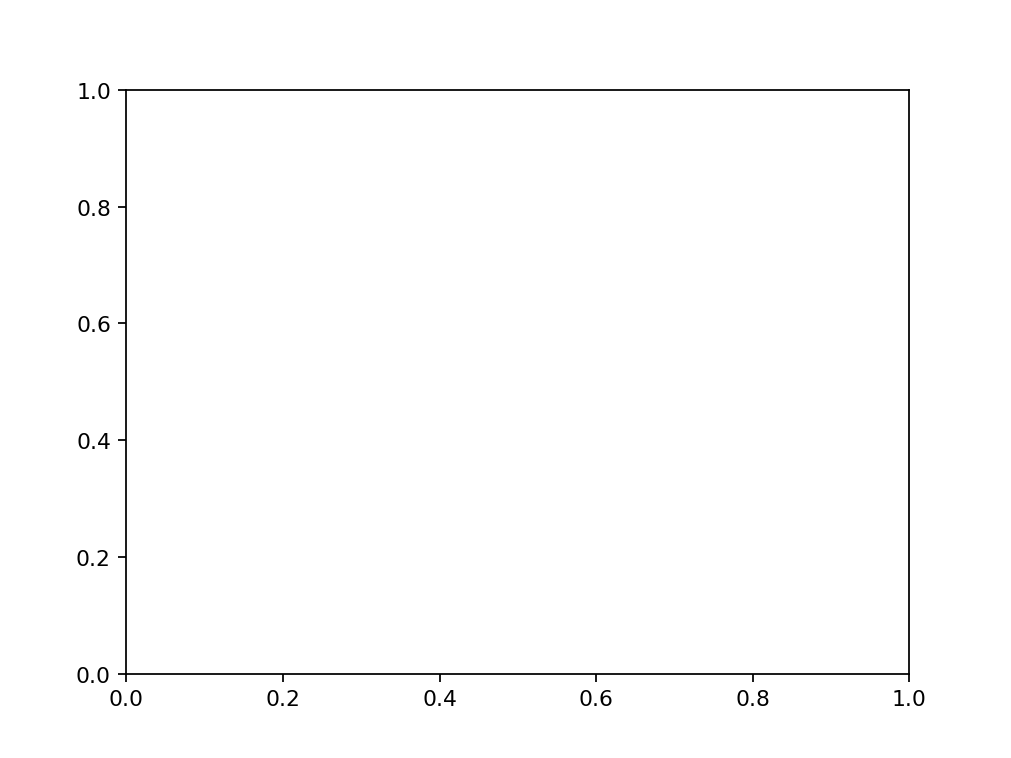

In [28]:
fig, ax = plt.subplots()
cutouts[0]?

In [19]:
row_hdu_map

{1: <astropy.io.fits.hdu.compressed.CompImageHDU at 0x7f5d409ff0a0>,
 2: <astropy.io.fits.hdu.compressed.CompImageHDU at 0x7f5d3cd10ac0>,
 3: <astropy.io.fits.hdu.compressed.CompImageHDU at 0x7f5d3cd12b90>,
 4: <astropy.io.fits.hdu.compressed.CompImageHDU at 0x7f5d3cd3d690>,
 5: <astropy.io.fits.hdu.compressed.CompImageHDU at 0x7f5d3cd7d180>,
 6: <astropy.io.fits.hdu.compressed.CompImageHDU at 0x7f5d3cdb00d0>,
 7: <astropy.io.fits.hdu.compressed.CompImageHDU at 0x7f5d3cdb08b0>,
 8: <astropy.io.fits.hdu.compressed.CompImageHDU at 0x7f5d3cd128c0>,
 9: <astropy.io.fits.hdu.compressed.CompImageHDU at 0x7f5d3cc47d00>,
 10: <astropy.io.fits.hdu.compressed.CompImageHDU at 0x7f5d3cd03850>,
 11: <astropy.io.fits.hdu.compressed.CompImageHDU at 0x7f5d3cd02260>,
 12: <astropy.io.fits.hdu.compressed.CompImageHDU at 0x7f5d3cc9fe50>,
 13: <astropy.io.fits.hdu.compressed.CompImageHDU at 0x7f5d3cd96020>,
 14: <astropy.io.fits.hdu.compressed.CompImageHDU at 0x7f5d3cd97be0>,
 15: <astropy.io.fits.hdu.com

<IPython.core.display.Javascript object>


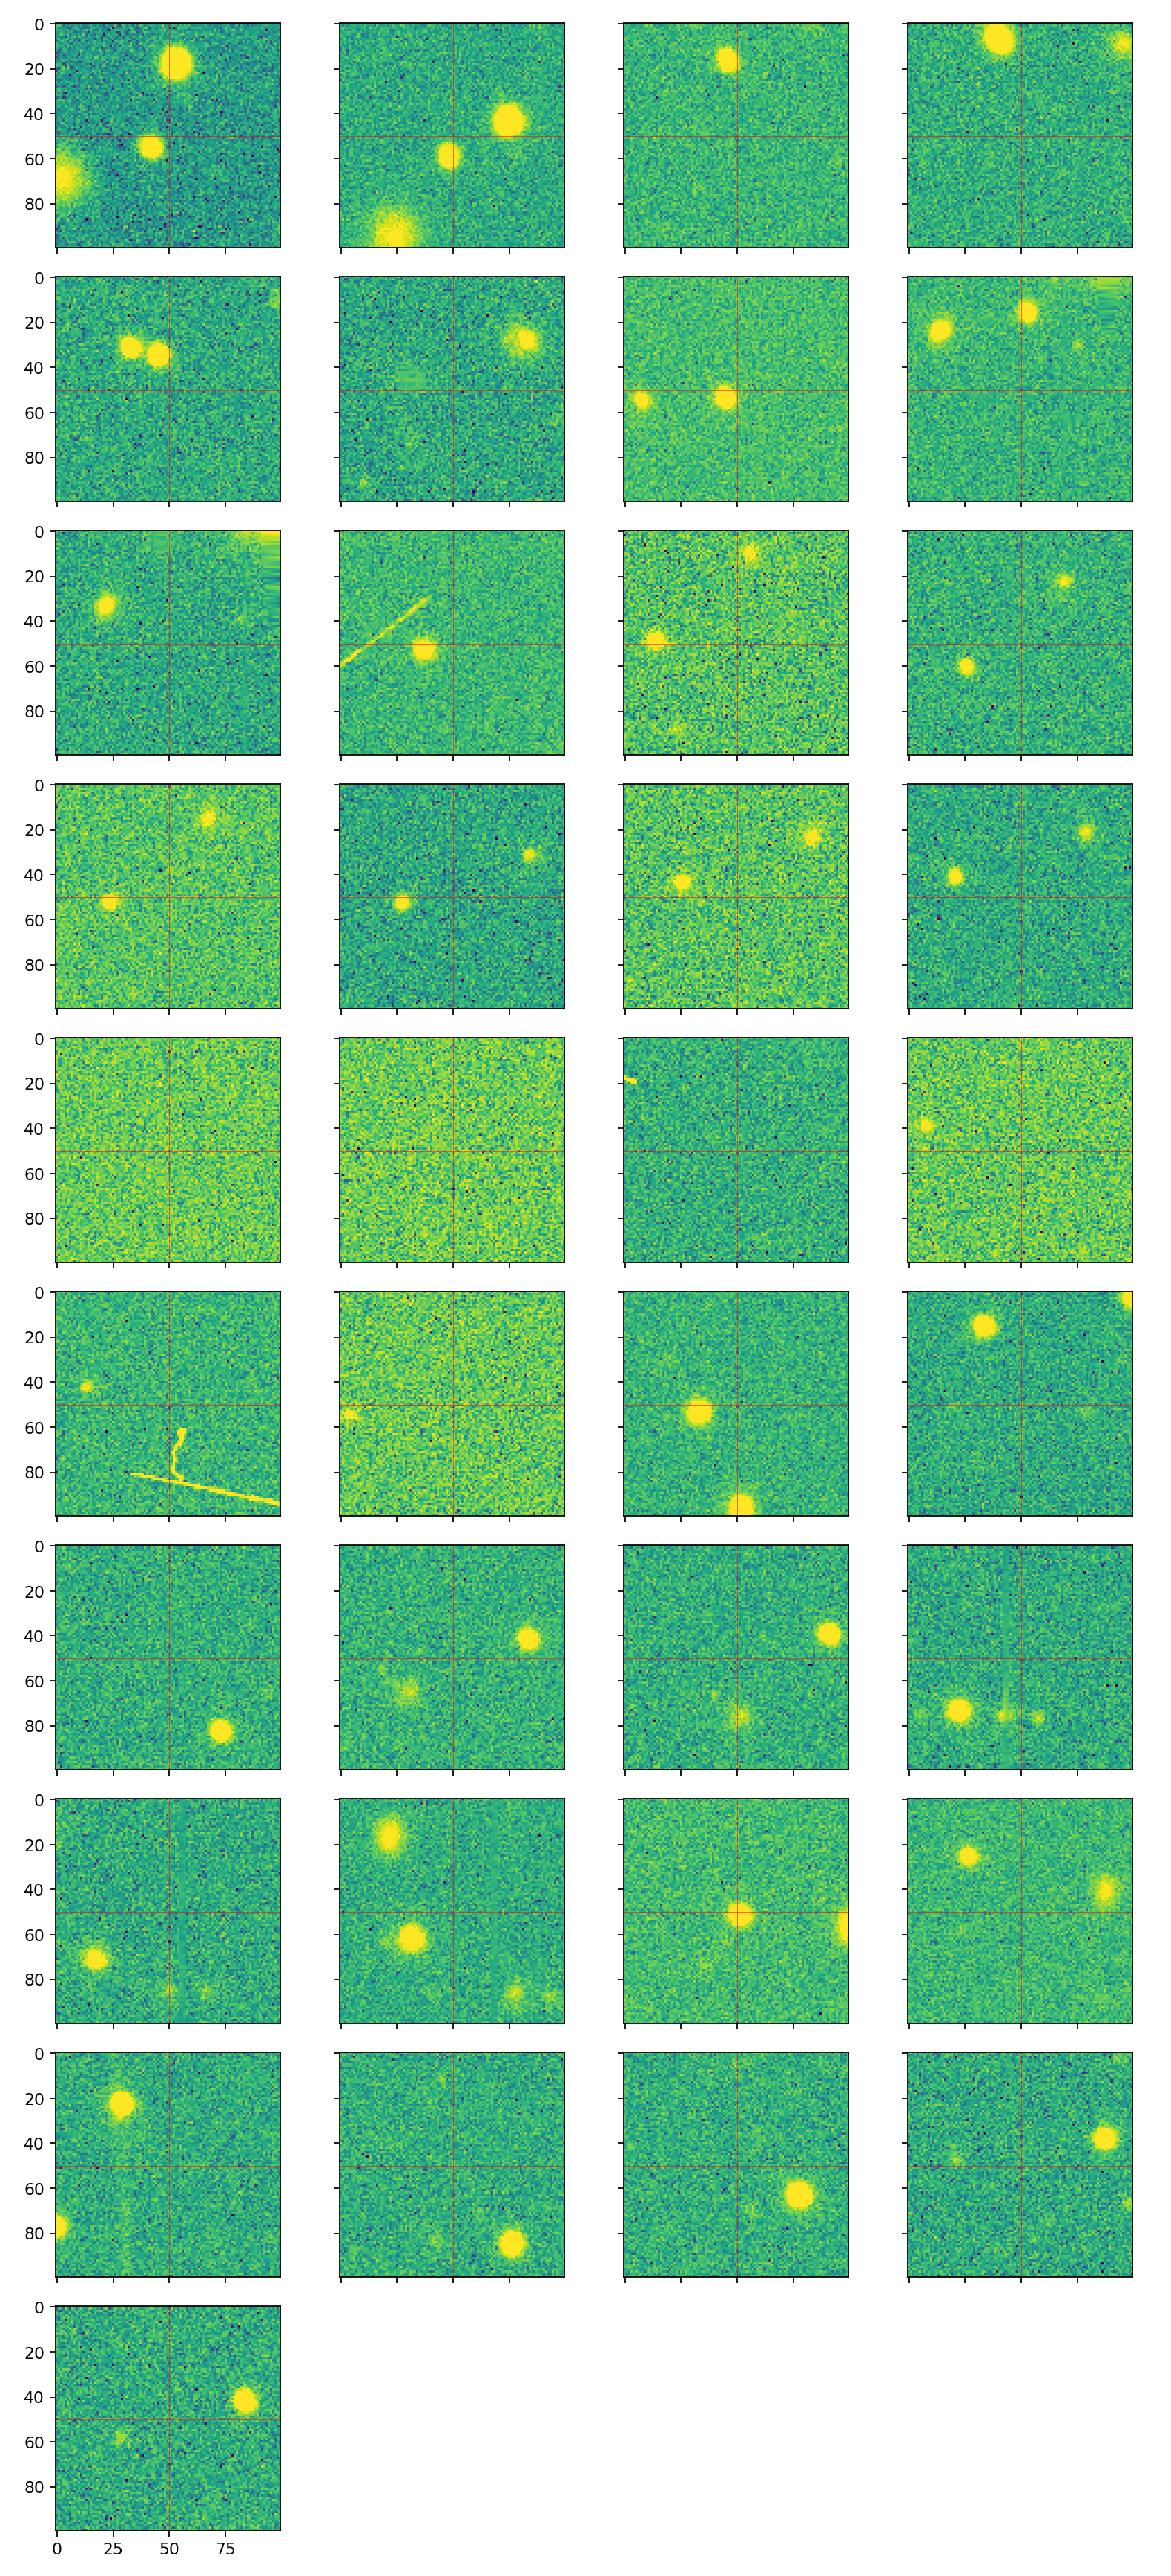

In [20]:
fig, axes = plt.subplots(ncols=4, nrows=10, figsize=(10, 22), sharex=True, sharey=True)
plot_cutouts(axes, cutouts)
fig.tight_layout()